In [51]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import numpy as np

from IPython.display import Image

from PIL import Image

In [52]:
# Scaling is it required with tensorflow gen?
# change the error to something else like similarity index
# take a part of the image as input and provide SR for that part only

In [53]:
train_dest_lr_dir = './../dataset_v3/train/LR/'
train_dest_hr_dir = './../dataset_v3/train/HR/'

test_dest_lr_dir = './../dataset_v3/test/LR/'
test_dest_hr_dir = './../dataset_v3/test/HR/'

In [54]:
def rescale(image):
    return image / 255.0

In [55]:
train_img_lr = image_dataset_from_directory(
    train_dest_lr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(175, 175),
    shuffle=False,
    seed=None,
    validation_split=0.1,
    subset='training',
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)


Found 13000 files belonging to 1 classes.
Using 11700 files for training.


In [56]:
train_img_hr = image_dataset_from_directory(
    train_dest_hr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(350, 350),
    shuffle=False,
    seed=None,
    validation_split=0.1,
    subset='training',
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)

Found 13000 files belonging to 1 classes.
Using 11700 files for training.


In [57]:
val_img_lr = image_dataset_from_directory(
    train_dest_lr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(175, 175),
    shuffle=False,
    seed=None,
    validation_split=0.1,
    subset='validation',
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)

Found 13000 files belonging to 1 classes.
Using 1300 files for validation.


In [58]:
val_img_hr = image_dataset_from_directory(
    train_dest_hr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(350, 350),
    shuffle=False,
    seed=None,
    validation_split=0.1,
    subset='validation',
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)

Found 13000 files belonging to 1 classes.
Using 1300 files for validation.


In [59]:
test_img_lr = image_dataset_from_directory(
    test_dest_lr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(175, 175),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)


Found 1200 files belonging to 1 classes.


In [60]:
test_img_hr = image_dataset_from_directory(
    test_dest_hr_dir,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=8,
    image_size=(350, 350),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='lanczos5',
    follow_links=False,
    crop_to_aspect_ratio=False,
).map(rescale)



Found 1200 files belonging to 1 classes.


In [61]:
image_batch_hr = next(iter(train_img_hr))

image_batch_lr = next(iter(train_img_lr))

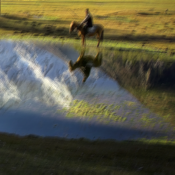

In [62]:
tf.keras.preprocessing.image.array_to_img(image_batch_lr[7])

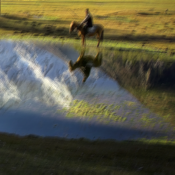

In [63]:
tf.keras.preprocessing.image.array_to_img(image_batch_lr[7])

In [64]:
# def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
#     """Creates an EDSR model."""
#     x_in = Input(shape=(None, None, 3))
#     x = b = Conv2D(num_filters, 3, padding='same')(x_in)
#     for i in range(num_res_blocks):
#         b = res_block(b, num_filters, res_block_scaling)
#     b = Conv2D(num_filters, 3, padding='same')(b)
#     x = Add()([x, b])

#     x = upsample(x, scale, num_filters)
#     x = Conv2D(3, 3, padding='same')(x)

#     return Model(x_in, x, name="edsr")

def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None, l2_reg=1e-4):
    """Creates an EDSR model."""
    x_in = Input(shape=(None, None, 3))
    x = b = Conv2D(num_filters, 3, padding='same', kernel_regularizer=l2(l2_reg))(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same', kernel_regularizer=l2(l2_reg))(x)

    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    """Creates an EDSR residual block."""
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x

def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        """Sub-pixel convolution."""
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return PixelShuffle(scale=factor)(x)

    if scale > 2:
        x = upsample_1(x, 2, name='upsample_1')
        x = upsample_1(x, 2, name='upsample_2')
    else:
        x = upsample_1(x, scale, name='upsample_1')

    return x


class PixelShuffle(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(PixelShuffle, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale)

    def get_config(self):
        config = super(PixelShuffle, self).get_config()
        config.update({"scale": self.scale})
        return config



In [65]:

# Create a single dataset with (input, target) pairs
# train_dataset = tf.data.Dataset.zip((list(train_img_lr.as_numpy_iterator()), list(train_img_hr.as_numpy_iterator())))

train_dataset = tf.data.Dataset.zip((train_img_lr, train_img_hr))
val_dataset = tf.data.Dataset.zip((val_img_lr, val_img_hr))

In [66]:
# def combined_loss(alpha=0.9):
#     def loss(y_true, y_pred):
#         mse = tf.reduce_mean(tf.square(y_true - y_pred))
#         ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
#         return alpha * (1.0 - ssim) + (1.0 - alpha) * mse
#     return loss

def combined_loss():
    def loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
        return mse
    return loss

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

In [67]:
# Create the EDSR model.
model = edsr(scale=2, num_filters=64, num_res_blocks=7, res_block_scaling=None)

# Compile the model

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=tf.keras.losses.MeanAbsoluteError())
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mean_squared_error') 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='mean_absolute_error')

In [68]:
model.summary()

Model: "edsr"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 6 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, None, 6 36928       conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, None, None, 6 36928       conv2d_18[0][0]                  
_______________________________________________________________________________________________

In [40]:
# model_v6
# epochs - 21
# Now you can train your model
model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,  # Add validation data here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/100
1553/1553 [==============================] - 391s 241ms/step - loss: 0.0729 - val_loss: 0.0549
Epoch 2/100
1553/1553 [==============================] - 390s 251ms/step - loss: 0.0652 - val_loss: 0.0522
Epoch 3/100
1553/1553 [==============================] - 393s 253ms/step - loss: 0.0636 - val_loss: 0.0540
Epoch 4/100
1553/1553 [==============================] - 393s 253ms/step - loss: 0.0630 - val_loss: 0.0491
Epoch 5/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0630 - val_loss: 0.0529
Epoch 6/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0616 - val_loss: 0.0471
Epoch 7/100
1553/1553 [==============================] - 391s 252ms/step - loss: 0.0610 - val_loss: 0.0477
Epoch 8/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0604 - val_loss: 0.0504
Epoch 9/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0600 - val_loss: 0.0496
Epoch 10/100
1553/1553 [=============

In [49]:
# model_v6
model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,  # Add validation data here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/100
1553/1553 [==============================] - 384s 247ms/step - loss: 0.0613 - val_loss: 0.0492
Epoch 2/100
1553/1553 [==============================] - 390s 251ms/step - loss: 0.0603 - val_loss: 0.0487
Epoch 3/100
1553/1553 [==============================] - 391s 252ms/step - loss: 0.0602 - val_loss: 0.0514
Epoch 4/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0596 - val_loss: 0.0488
Epoch 5/100
1553/1553 [==============================] - 392s 252ms/step - loss: 0.0595 - val_loss: 0.0489
Epoch 6/100
1553/1553 [==============================] - 393s 253ms/step - loss: 0.0590 - val_loss: 0.0491
Epoch 7/100
1553/1553 [==============================] - 393s 253ms/step - loss: 0.0584 - val_loss: 0.0482
Epoch 8/100
1553/1553 [==============================] - 394s 254ms/step - loss: 0.0583 - val_loss: 0.0491
Epoch 9/100
1553/1553 [==============================] - 394s 254ms/step - loss: 0.0586 - val_loss: 0.0472
Epoch 10/100
1553/1553 [=============

In [69]:
# model_v7

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,  # Add validation data here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/100
1463/1463 [==============================] - 1165s 789ms/step - loss: 0.0594 - val_loss: 0.0580
Epoch 2/100
1463/1463 [==============================] - 2157s 1s/step - loss: 0.0507 - val_loss: 0.0554
Epoch 3/100
1463/1463 [==============================] - 398s 272ms/step - loss: 0.0487 - val_loss: 0.0509
Epoch 4/100
1463/1463 [==============================] - 404s 276ms/step - loss: 0.0476 - val_loss: 0.0477
Epoch 5/100
1463/1463 [==============================] - 405s 277ms/step - loss: 0.0468 - val_loss: 0.0474
Epoch 6/100
1463/1463 [==============================] - 404s 276ms/step - loss: 0.0462 - val_loss: 0.0451
Epoch 7/100
1463/1463 [==============================] - 404s 276ms/step - loss: 0.0456 - val_loss: 0.0458
Epoch 8/100
1463/1463 [==============================] - 404s 276ms/step - loss: 0.0452 - val_loss: 0.0455
Epoch 9/100
1463/1463 [==============================] - 404s 276ms/step - loss: 0.0448 - val_loss: 0.0449
Epoch 10/100
1463/1463 [==============

In [70]:
model.save("edsr_fullimage_sr_model_v7.h5")

c:\Users\Ashwin RK\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [71]:
test_dataset = tf.data.Dataset.zip((test_img_lr, test_img_hr))

loss = model.evaluate(test_dataset)
print('Test loss:', loss)

150/150 [==============================] - 15s 98ms/step - loss: 0.0627
Test loss: 0.06269253045320511


In [35]:
test_dataset = tf.data.Dataset.zip((test_img_lr, test_img_hr))

loss = model.evaluate(test_dataset)
print('Test loss:', loss)

50/50 [==============================] - 4s 84ms/step - loss: 0.0984
Test loss: 0.09843159466981888


In [20]:
from tensorflow.keras.models import load_model

model_lodaded = load_model('edsr_fullimage_sr_model_v6.h5', custom_objects={'PixelShuffle': PixelShuffle})

In [21]:
test_dataset = tf.data.Dataset.zip((test_img_lr, test_img_hr))

loss = model_lodaded.evaluate(test_dataset)
print('Test loss:', loss)

150/150 [==============================] - 38s 245ms/step - loss: 0.1468
Test loss: 0.14676429331302643


In [49]:


# Load the parts of the image
parts = [load_img(test_dest_lr_dir+f'/img_0_4_{i}.png', target_size=(175, 175)) for i in range(4)]

# Convert the parts to numpy arrays and rescale them
parts_arrays = [img_to_array(part) / 255.0 for part in parts]

# Add an extra dimension to match the batch shape expected by the model
parts_arrays = [np.expand_dims(part_array, axis=0) for part_array in parts_arrays]

# Make a prediction for each part
predictions = [model_lodaded.predict(part_array) for part_array in parts_arrays]

# Remove the extra dimension and rescale the pixel values
predictions = [np.squeeze(prediction, axis=0) * 255.0 for prediction in predictions]

# Convert to PIL Images
predicted_parts = [array_to_img(prediction) for prediction in predictions]

# Combine the predicted parts
combined_image = Image.new('RGB', (700, 700))
combined_image.paste(predicted_parts[0], (0, 0))
combined_image.paste(predicted_parts[1], (0, 350))
combined_image.paste(predicted_parts[2], (350, 0))
combined_image.paste(predicted_parts[3], (350,350 ))

combined_image.show()


In [50]:
# Load the parts of the HR image
hr_parts = [load_img(test_dest_hr_dir+f'/img_0_4_{i}.png', target_size=(350, 350)) for i in range(4)]

# Combine the HR parts
combined_hr_image = Image.new('RGB', (700, 700))
combined_hr_image.paste(hr_parts[0], (0, 0))
combined_hr_image.paste(hr_parts[1], (0, 350))
combined_hr_image.paste(hr_parts[2], (350, 00))
combined_hr_image.paste(hr_parts[3], (350, 350))

# Display the combined HR image
combined_hr_image.show()

In [72]:
def calculate_metrics(dataset, model):
    psnr_values = []
    ssim_values = []

    for lr, hr in dataset:
        # Generate SR images from the LR images
        sr = model.predict(lr)

        # Calculate PSNR and SSIM for each image in the batch
        for i in range(sr.shape[0]):
            psnr = tf.image.psnr(hr[i], sr[i], max_val=1.0)
            ssim = tf.image.ssim(hr[i], sr[i], max_val=1.0)

            psnr_values.append(psnr.numpy())
            ssim_values.append(ssim.numpy())

    # Calculate the average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Calculate metrics for the training and test datasets
train_psnr, train_ssim = calculate_metrics(train_dataset, model_lodaded)
test_psnr, test_ssim = calculate_metrics(test_dataset, model_lodaded)

print(f'Train PSNR: {train_psnr}, Train SSIM: {train_ssim}')
print(f'Test PSNR: {test_psnr}, Test SSIM: {test_ssim}')


Train PSNR: 23.77392578125, Train SSIM: 0.7487143874168396
Test PSNR: 21.38936424255371, Test SSIM: 0.6321719288825989


In [ ]:
model.save